In [1]:
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
import compute_diversity_measures
import seaborn as sns

In [2]:
genome_length = 9228

### import mutations

In [3]:
fname_mutations = '../../resources/run_workflow/results_cluster/parental_stock_ref_Cha/all_mutations.csv'

df = pd.read_csv(fname_mutations)
df = df.drop(['Unnamed: 0'], axis=1)

df['genotype'] = 'parental_stock_Cha'
df['passage'] = df['date']
df['replicate'] = df['patient']

# add information
df['Frq1'] = pd.to_numeric(df['Frq1'], errors='coerce')
df['Frq2'] = pd.to_numeric(df['Frq2'], errors='coerce')
df['Frq3'] = pd.to_numeric(df['Frq3'], errors='coerce')

df['n_reads_var'] = df['Rvar'] + df['Fvar']
df['coverage'] = df['Rtot'] + df['Ftot']
df['frequency'] = df['n_reads_var'] / df['coverage']
df['Frq_ave'] = df[['Frq1','Frq2','Frq3']].mean(axis=1)

df['position'] = df['Pos']

In [4]:
df.shape

(1719, 27)

In [5]:
df.head(5)

,Chromosome,Pos,Ref,Var,Frq1,Frq2,Frq3,Pst1,Pst2,Pst3,...,patient,date,genotype,passage,replicate,n_reads_var,coverage,frequency,Frq_ave,position
0,MK645242.1,86,T,-,0.0001,0.0001,0.0001,1.0000,0.9982,0.9939,...,parental_stock,DCV_PO,parental_stock_Cha,DCV_PO,parental_stock,12,132631,0.000090,0.00010,86
1,MK645242.1,87,A,-,0.0001,0.0001,NaN,1.0000,0.9982,-,...,parental_stock,DCV_PO,parental_stock_Cha,DCV_PO,parental_stock,10,132309,0.000076,0.00010,87
2,MK645242.1,108,T,C,NaN,0.0004,0.0003,-,0.9286,1.0000,...,parental_stock,DCV_PO,parental_stock_Cha,DCV_PO,parental_stock,66,115669,0.000571,0.00035,108
3,MK645242.1,109,C,A,0.0021,0.0018,0.0420,0.9875,1.0000,1.0000,...,parental_stock,DCV_PO,parental_stock_Cha,DCV_PO,parental_stock,1219,114659,0.010632,0.01530,109
4,MK645242.1,130,T,-,0.0005,0.0003,0.0004,1.0000,1.0000,1.0000,...,parental_stock,DCV_PO,parental_stock_Cha,DCV_PO,parental_stock,33,93890,0.000351,0.00040,130


### Filtering

In [6]:
# Post-processing filtering of mutation calling

# filter out where Frq_ave == 0.0 
# that is something unexpected happening in ShoRAH which is due to the super high coverage
df = df[df['Frq_ave']!=0]

# strand bias test 
df = df[df['Pval']>=0.05]

# minimum read support
minimum_read_support = 10 
df = df[df['n_reads_var']>=minimum_read_support]

In [7]:
df.shape

(317, 27)

In [8]:
# minimum mutation frequency
minimum_frequency_threshold = 0.0001 
df = df[df['frequency']>minimum_frequency_threshold]

In [9]:
df.shape

(287, 27)

## n_polymorphisms_parental_stock

In [10]:
n_polymorphisms_parental_stock = compute_diversity_measures.number_of_polymorphisms(df)
n_polymorphisms_parental_stock

265

### Mutation frequency spectrum

In [11]:
mutation_spectrum_bins = [(0.0001,0.001),(0.001,0.01), (0.01,0.1), (0.1, 0.98), (0.98,1)]
mutation_spectrum_bins_labels = [str(curr_bin) for curr_bin in mutation_spectrum_bins]

In [12]:
def mutation_spectrum(df_mutations, bins):
    counts = np.zeros(len(bins))
    for i, curr_bin in enumerate(bins):
        df_temp = df_mutations[df_mutations["frequency"] > curr_bin[0]]
        df_temp = df_temp[df_temp["frequency"] <= curr_bin[1]]
        #variant_positions = df_temp["position"].unique()
        #counts[i] = len(variant_positions)
        counts[i] = df_temp.shape[0]
    return list(counts)

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_35665/1612995263.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=mutation_spectrum_bins_labels,rotation = 45, size=25)


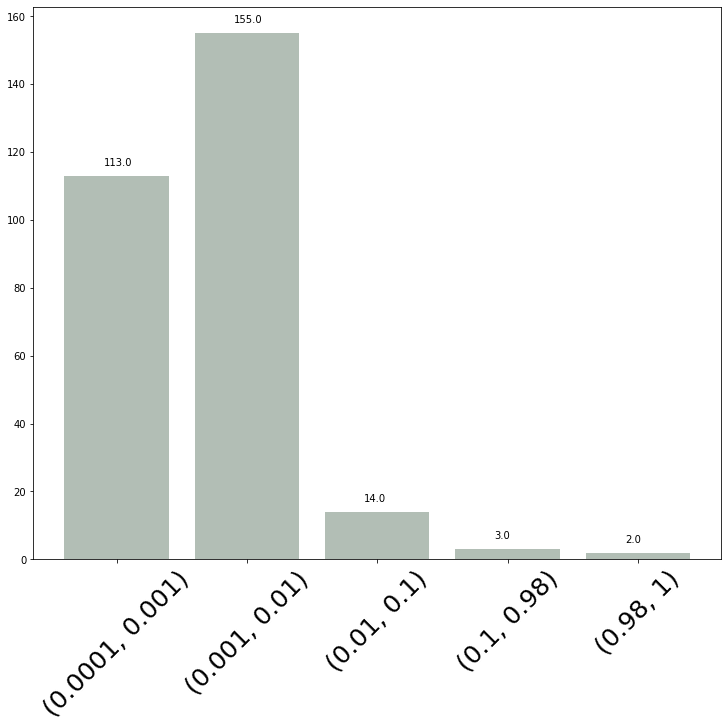

In [13]:
# parental stock color #B2BEB5

mut_spec = mutation_spectrum(df, mutation_spectrum_bins)
bins = mutation_spectrum_bins

fig, ax = plt.subplots(1,1, figsize=(10, 10),constrained_layout=True, sharey=True, sharex=True)


ax.bar(mutation_spectrum_bins_labels, mut_spec, color="#B2BEB5")
ax.set_xticklabels(labels=mutation_spectrum_bins_labels,rotation = 45, size=25)

for i, v in enumerate(mut_spec):
    ax.text( i - 0.1, v + 3, str(v),color = 'black')

In [15]:
fig.savefig("./000__Manuscript_figures/Supplementary_Figure_2__mutation_spectrum_parental_stock_wrt_Cha.pdf")
fig.savefig("./000__Manuscript_figures/Supplementary_Figure_2__mutation_spectrum_parental_stock_wrt_Cha.svg")